In [32]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
sb.set_style("dark")

sys.path.append(os.path.join(os.getcwd(), '..','src'))

In [33]:
from optimal_gardening import *

In [34]:
import gurobipy as grb

### Mixed Integer Programming

### Gather Input Data

$P: \:Set \:of \:plants \:(indexed \:by \:p)$

In [35]:
plant_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35], dtype=int64)

$B: \:Set \:of \:beds \:(indexed \:by \:b)$

In [36]:
bed_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41], dtype=int64)

$T: \:Set \:of \:years \:(indexed \:by \:t)$

In [37]:
year_index

array([0, 1, 2])

$R: \:Set \:of \:plant \:preferences \:(indexed \:by \:p)$

In [38]:
preferences

array([ 6.5,  5.5,  5.5,  7.5,  5.5,  5.5,  5.5,  5.5,  8. ,  8.5,  6. ,
        5. ,  4. ,  6. ,  2.5,  7.5,  5. ,  4. ,  8. ,  4.5,  5. ,  5. ,
        5.5,  5.5,  5.5,  5. ,  6. ,  5. , 10. ,  5.5,  7. ,  6. ,  7. ,
        7. ,  5.5,  4.5])

$S: \:Ability \:to \:plant \:in \:bed \:given \:the \:sun \:constraint \:(indexed \:by \:p, \:b)$

In [39]:
#just take the sun constraint for the first year
sun = sun_constraint[:,:,0]
sun

array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

$P_{e}: \:Subset \:of \:plants \:that \:are \:perennials $

In [40]:
perennials

[1, 5, 13, 20, 24, 25, 28, 29, 30]

$P_{d}: \:Subset \:of \:plants \:that \:increase \:the \:risk \:of \:diseases \:if \:planted \:in \:same \:bed \:YoY$

In [41]:
problem_plants

[33]

$U: \:Maximum \:yummy \:score$

In [42]:
max_yums

1260.0

$G: \:Number \:of \:plants $

In [43]:
num_plants

36

$W: \:Objective \;Weights $

In [44]:
mip_weights = {'yummy_score': 1, 'variety_score': 0}
mip_weights

{'yummy_score': 1, 'variety_score': 0}

### Create a Model

In [45]:
try:
    m.reset()
except:
    m = grb.Model('optimus-veg')

Discarded solution information


### Add Decision Variables

$x \:(binary): \;Whether \;or \;not \;to \;grow \;plant \;(p) \;in \;bed \;(b) \;during \;year \;(t) $

In [46]:
#whether or not plant (p) is put in bed (b) in year (t). Binary
x = m.addVars(plant_index,bed_index,year_index,vtype=grb.GRB.BINARY)
print(f'Number of x variables: {len(x)}')
x

Number of x variables: 4536


{(0, 0, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 0, 1): <gurobi.Var *Awaiting Model Update*>,
 (0, 0, 2): <gurobi.Var *Awaiting Model Update*>,
 (0, 1, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 1, 1): <gurobi.Var *Awaiting Model Update*>,
 (0, 1, 2): <gurobi.Var *Awaiting Model Update*>,
 (0, 2, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 2, 1): <gurobi.Var *Awaiting Model Update*>,
 (0, 2, 2): <gurobi.Var *Awaiting Model Update*>,
 (0, 3, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 3, 1): <gurobi.Var *Awaiting Model Update*>,
 (0, 3, 2): <gurobi.Var *Awaiting Model Update*>,
 (0, 4, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 4, 1): <gurobi.Var *Awaiting Model Update*>,
 (0, 4, 2): <gurobi.Var *Awaiting Model Update*>,
 (0, 5, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 5, 1): <gurobi.Var *Awaiting Model Update*>,
 (0, 5, 2): <gurobi.Var *Awaiting Model Update*>,
 (0, 6, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 6, 1): <gurobi.Var *Awaiting Model Update*>,


$y \:(binary): \;Whether \;or \;not \;plant \;(p) \;is \;grown \;anywhere \;in \;any \;year $

In [47]:
#whether or not plant p is planted (anywhere)
y = m.addVars(plant_index,vtype=grb.GRB.BINARY)
print(f'Number of y variables: {len(y)}')
y

Number of y variables: 36


{0: <gurobi.Var *Awaiting Model Update*>,
 1: <gurobi.Var *Awaiting Model Update*>,
 2: <gurobi.Var *Awaiting Model Update*>,
 3: <gurobi.Var *Awaiting Model Update*>,
 4: <gurobi.Var *Awaiting Model Update*>,
 5: <gurobi.Var *Awaiting Model Update*>,
 6: <gurobi.Var *Awaiting Model Update*>,
 7: <gurobi.Var *Awaiting Model Update*>,
 8: <gurobi.Var *Awaiting Model Update*>,
 9: <gurobi.Var *Awaiting Model Update*>,
 10: <gurobi.Var *Awaiting Model Update*>,
 11: <gurobi.Var *Awaiting Model Update*>,
 12: <gurobi.Var *Awaiting Model Update*>,
 13: <gurobi.Var *Awaiting Model Update*>,
 14: <gurobi.Var *Awaiting Model Update*>,
 15: <gurobi.Var *Awaiting Model Update*>,
 16: <gurobi.Var *Awaiting Model Update*>,
 17: <gurobi.Var *Awaiting Model Update*>,
 18: <gurobi.Var *Awaiting Model Update*>,
 19: <gurobi.Var *Awaiting Model Update*>,
 20: <gurobi.Var *Awaiting Model Update*>,
 21: <gurobi.Var *Awaiting Model Update*>,
 22: <gurobi.Var *Awaiting Model Update*>,
 23: <gurobi.Var *Awa

### Add Objective

Maximize the weighted sum of the yummy score and the variety score

$maximize \;\; w_{1}\dfrac{\displaystyle\sum_{p=0}^{P}\displaystyle\sum_{b=0}^{B}\displaystyle\sum_{t=0}^{T}R_{p}x_{pbt}}{U} + w_{2}\dfrac{\displaystyle\sum_{p=0}^{P}y_{p}}{G} $

In [48]:
obj = m.setObjective((
    mip_weights['yummy_score']*grb.quicksum(preferences[p]*grb.quicksum(x[p,b,t] for b in bed_index for t in year_index) for p in plant_index)/max_yums + 
    mip_weights['variety_score']*(grb.quicksum(y[p] for p in plant_index)/num_plants)
                        ),sense=grb.GRB.MAXIMIZE)

### Add Constraints

Only allow at most one plant to be assigned to each bed in each year

$\displaystyle\sum_{p=0}^{P}x_{pbt} \leq 1  \;\;\;\;\forall \,b \in B , t \in T$

In [49]:
onePerBedConstraint = m.addConstrs((grb.quicksum(x[p,b,t] for p in plant_index) <= 1 for b in bed_index for t in year_index))

Plant cannot be grown in bed if the bed does not have the proper sun requirements to successfully grow the given plant

$x_{pbt} \leq S_{pb}  \;\;\;\;\forall \,p \in P_{e},\, b \in B ,\, t \in T$

In [50]:
sunConstraint = m.addConstrs((x[p,b,t]<=sun[p,b] for p in plant_index for b in bed_index for t in year_index))

Perennial plants must be assigned to the same bed once they are first planted

$x_{pbt} \geq x_{pbt-1}  \;\;\;\;\forall \,p \in P_{e},\, b \in B ,\, t = 1..T$

In [51]:
perennialConstraint = m.addConstrs(x[p,b,t] >= x[p,b,t-1] for p in plant_index if p in perennials for b in bed_index for t in year_index[1:])

Plants at risk of spreading soil-born diseases cannot be planted in the same bed year-over-year

$x_{pbt} \leq 1-x_{pbt-1}  \;\;\;\;\forall \,p \in P_{d},\, b \in B ,\, t = 1..T$

In [52]:
diseaseConstraint = m.addConstrs(x[p,b,t] <= 1 - x[p,b,t-1] for p in plant_index if p in problem_plants for b in bed_index for t in year_index[1:])

Relate x to y, so that planting x[p,b,t] anywhere at any point will trigger y[p] to be 1

$\displaystyle\sum_{b=0}^{B}\displaystyle\sum_{t=0}^{T} x_{pbt} \geq y_{p}  \;\;\;\;\forall \,p \in P$

In [53]:
#define y as it relates to x. You can only set y[p] to 1 if you actually plant it somewhere at some point
yxRelationConstraint = m.addConstrs((grb.quicksum(x[p,b,t] for b in bed_index for t in year_index)>= y[p] for p in plant_index))

### Solve

In [54]:
m.optimize()

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 11076 rows, 9144 columns and 30648 nonzeros
Model fingerprint: 0xc5fb10dd
Variable types: 0 continuous, 9144 integer (9144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 8e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.5833333
Presolve removed 11076 rows and 9144 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds
Thread count was 1 (of 12 available processors)

Solution count 2: 0.866667 
No other solutions better than 0.866667

Optimal solution found (tolerance 1.00e-04)
Best objective 8.666666666667e-01, best bound 8.666666666667e-01, gap 0.0000%


### Solution Analysis

In [55]:
#get solution in same format as heuristic approach
mip_plan = np.zeros(shape=(num_plants,num_beds,num_years))

for p in plant_index:
    for b in bed_index:
        for t in year_index:
            if x[p,b,t].x==1:
                mip_plan[p,b,t] = 1

In [56]:
mip_obs = round(m.getObjective().getValue()*100,1)
mip_yums = compute_yummy_score(mip_plan,preferences,max_yums)
mip_variety = compute_variety_score(mip_plan,num_plants)

print(f'Overall MIP Objective: {mip_obs}')
print(f'MIP Yummy Score: {mip_yums}')
print(f'MIP Variety Score: {mip_variety}')

Overall MIP Objective: 86.7
MIP Yummy Score: 86.7
MIP Variety Score: 8.3


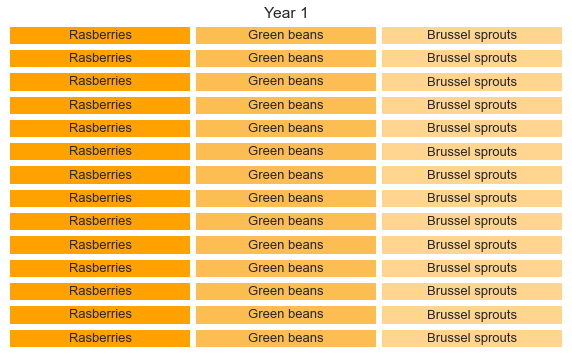

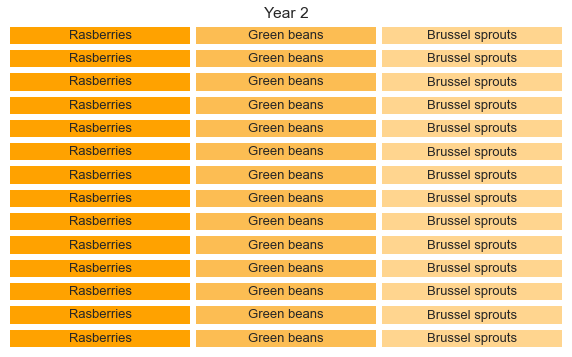

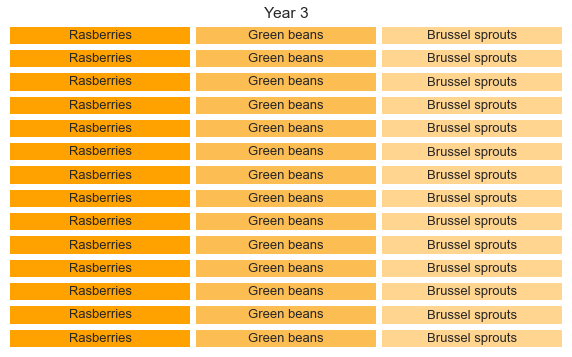

In [57]:
df_mip_plan = annual_bed_plan(mip_plan,bed_info,plant_info,bed_index,year_index)
visualize_plan(df_mip_plan,bed_index,years)